In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Setup

In [ ]:
import sys, os
from astropy.table import Table, vstack
from astropy.io import fits

basedir = "../../"
for subdir in [""]:
    sys.path.append(basedir+subdir)
from misc import *
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import json
from scipy.special     import erfc

sys.path.append('..')
from mc_forecast import mc_forecast
from forecast_utils import *

In [5]:
from matplotlib.pyplot import rc
rc('mathtext', **{'fontset':'cm'})
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["font.family"] = "serif"


In [6]:
m_bands = ['M411','M438','M464','M490','M517']
band_z = {
    'M411':[2.26,2.56],
    'M438':[2.47,2.77],
    'M464':[2.68,2.98],
    'M490':[2.89,3.2],
    'M517':[3.1,3.41]
}

In [7]:
cosmo = get_cosmo_P18()
h = cosmo.h()

In [8]:
rbins = np.geomspace(0.4,45,9)[1:]
RwR = np.sqrt(rbins[1:]*rbins[:-1])


In [10]:
fint_list = np.loadtxt(basedir+'data_measurements/fint_v4/pessimistic.txt')
fint_list += np.loadtxt(basedir+'data_measurements/fint_v4/optimistic.txt')
fint_list /= 2

fn = basedir+'data_measurements/wR_v4/lae_5bins.json'
data = json.load(open(fn,'r'))

datwt_array = []
for j, band in enumerate(m_bands):
    fint = fint_list[j]    
    datwt_array.append(np.array(data['z%d'%(j+1)]['wt']) / (1-fint)**2)
datwt_array = np.array(datwt_array)

### Loading the data catalog (unnecessary to just produce plots)

In [11]:
fn = "/pscratch/sd/h/hebina/IBIS/selection_clustering/catalogs/clustering_cat_v4.fits"
d = Table.read(fn)
radius = 1.4
ra0,dec0 = 35.75, -4.75
area = 1.4**2 * np.pi
coord_cut = angular_distance(d['RA'],d['DEC'],ra0,dec0)<radius
d = d[coord_cut]

fn = "/pscratch/sd/h/hebina/IBIS/selection_clustering/catalogs/redshift_cat_v4.fits"
d_spec = Table.read(fn)
radius = 1.4
ra0,dec0 = 35.75, -4.75
area = 1.4**2 * np.pi
coord_cut = angular_distance(d_spec['RA'],d_spec['DEC'],ra0,dec0)<radius
d_spec = d_spec[coord_cut]

In [12]:
use_mask = True

# $\chi^2$ fits

In [11]:
rbins = np.geomspace(0.4,45,9)[:-1]
RwR = np.sqrt(rbins[1:]*rbins[:-1])
lgMc_list = [11.00,11.25,11.50,11.75,12.0,12.25,12.5]
alph_list = [.33,.5,.66]#,1.]
sigm_list = [.33,.5,.66]#,1.]
kapp_list = [1]
plat_list = [5,10]
chi2_arr = [];hod_arr = [];r0_arr = [];fsat_arr = []

fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/hod/large_grid_c000_ph100_z2.5_r.json'
lae = json.load(open(fn,"r"))

for lgMcut in lgMc_list:
  for plateau in plat_list:
    lgM1 = lgMcut + np.log10(plateau)
    for alph in alph_list:
      for sigm in sigm_list:
        for kappa in kapp_list:
          # hod_params = {'logM_cut':11.75,'logM1':12.45,'sigma':0.66,'kappa':1.00,'alpha':1.0}
          hod_params = {'logM_cut':lgMcut,'logM1':lgM1,'sigma':sigm,'kappa':kappa,'alpha':alph}      
          forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                                   band_z['M411'][0], band_z['M517'][1], hod_params, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                                   m_bands=['M411','M438'],zbox=2.5)
          assert forecast.check_hod_exists()
          # forecast.make_cat(overwrite=False)
          # forecast.compute_wR(overwrite=False)
          c2, tmp1, tmp2, _ = forecast.chi2_wR(datwt_array[:2])
          hod_arr.append(hod_params)
          chi2_arr.append(c2)
        
          rr = lae['R']
          for i,samp in enumerate(lae['mocks']):
              tmp = True
              for pp in hod_params.keys():
                  ppidx = lae['hodkeys'].index(pp)
                  tmp &= hod_params[pp]==samp['hod'][ppidx]
              if tmp: break
          assert tmp
          xi = np.array(samp['xi0'])
          r0_arr.append(5*interp1d(rr,xi)(5)**(1/1.8))
          fsat_arr.append(samp['fsat'])
          # del lae['mocks'][i]

In [12]:
chi2_arr_z1 = chi2_arr
r0_arr_z1 = r0_arr
fsat_arr_z1 = fsat_arr

In [13]:
rbins = np.geomspace(0.4,45,9)[:-1]
RwR = np.sqrt(rbins[1:]*rbins[:-1])
lgMc_list = [11.00,11.25,11.50,11.75,12.0,12.25,12.5]
alph_list = [.33,.5,.66]#,1.]
sigm_list = [.33,.5,.66]#,1.]
kapp_list = [1]
plat_list = [5,10]
chi2_arr = [];hod_arr = [];r0_arr = [];fsat_arr = []

fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/hod/large_grid_c000_ph100_z3.0_r.json'
lae = json.load(open(fn,"r"))
for lgMcut in lgMc_list:
  for plateau in plat_list:
    lgM1 = lgMcut + np.log10(plateau)
    for alph in alph_list:
      for sigm in sigm_list:
        for kappa in kapp_list:
          # hod_params = {'logM_cut':11.75,'logM1':12.45,'sigma':0.66,'kappa':1.00,'alpha':1.0}
          hod_params = {'logM_cut':lgMcut,'logM1':lgM1,'sigma':sigm,'kappa':kappa,'alpha':alph}      
          forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                                   band_z['M411'][0], band_z['M517'][1], hod_params, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                                   m_bands=['M464','M490','M517'],zbox=3.0)
          assert forecast.check_hod_exists()
          # forecast.make_cat(overwrite=False)
          # forecast.compute_wR(overwrite=False)
          c2, tmp1, tmp2, _ = forecast.chi2_wR(datwt_array[2:])
          hod_arr.append(hod_params)
          chi2_arr.append(c2)
        
          rr = lae['R']
          for i,samp in enumerate(lae['mocks']):
              tmp = True
              for pp in hod_params.keys():
                  ppidx = lae['hodkeys'].index(pp)
                  tmp &= hod_params[pp]==samp['hod'][ppidx]
              if tmp: break
          assert tmp
          xi = np.array(samp['xi0'])
          r0_arr.append(5*interp1d(rr,xi)(5)**(1/1.8))
          fsat_arr.append(samp['fsat'])
          # del lae['mocks'][i]

In [14]:
chi2_arr_z2 = chi2_arr
r0_arr_z2 = r0_arr
fsat_arr_z2 = fsat_arr

In [15]:
bestfit_dict = {'z1':{'z':2.5,
                      'r0':r0_arr_z1,
                      'chi2':chi2_arr_z1,
                      'fsat':fsat_arr_z1,
                     },
                'z2':{'z':3.0,
                      'r0':r0_arr_z2,
                      'chi2':chi2_arr_z2,
                      'fsat':fsat_arr_z2,
                     },
               }
import json
with open('r0_arr.json', 'w') as fp:
    json.dump(bestfit_dict, fp)


In [16]:
r0_arr_z1[np.argmin(chi2_arr_z1)],hod_arr[np.argmin(chi2_arr_z1)],fsat_arr_z1[np.argmin(chi2_arr_z1)]

(3.2765219121667934,
 {'logM_cut': 11.25,
  'logM1': 11.948970004336019,
  'sigma': 0.66,
  'kappa': 1,
  'alpha': 0.33},
 0.121941703746695)

In [17]:
np.argmin(chi2_arr_z2),r0_arr_z2[np.argmin(chi2_arr_z2)],hod_arr[np.argmin(chi2_arr_z2)],fsat_arr_z2[np.argmin(chi2_arr_z2)]

(77,
 4.1257453831492095,
 {'logM_cut': 12.0,
  'logM1': 12.698970004336019,
  'sigma': 0.66,
  'kappa': 1,
  'alpha': 0.5},
 0.029727907209998516)

In [18]:
np.max(fsat_arr_z1), np.max(fsat_arr_z2)

(0.2591454352403251, 0.23841780582626115)

# Final figures

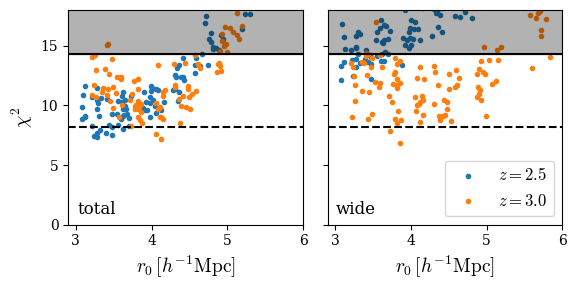

In [13]:
fig,axs = plt.subplots(1,2,figsize=(6,3))
for i in range(2):
    if i==0: fn = basedir+'mc/ibis_tertiary44_v4.2/r0_arr.json'
    else: fn = basedir+'mc/ibis_tertiary44_bright_v4.2/r0_arr.json'
    dd = json.load(open(fn,'r'))
    ax = axs[i]
    ax.scatter(dd['z1']['r0'],dd['z1']['chi2'],marker='.')
    ax.scatter(dd['z2']['r0'],dd['z2']['chi2'],marker='.')
    ax.set_xlabel(r'$r_0\,[h^{-1}\text{Mpc}]$',fontsize=14)

    if i==0: ax.set_xlim(2.9,6)
    else: ax.set_xlim(2.9,6)
    ax.set_ylim(0,18)
    # ax.grid(alpha=.8,ls='--')

    ax.axhline(8.18,c='k',ls='--')
    ax.axhline(14.34,c='k',ls='-')
    ax.fill_between(np.linspace(2,7),14.34, 30,color='k',alpha=.3)

    if i==0:
        ax.set_ylabel(r'$\chi^2$',fontsize=14)
        ax.set_title(r'total',y=.01,x=.12)
    else:
        ax.set_yticklabels([])
        ax.scatter([],[],c='C0',label=r'$z=2.5$',marker='.')
        ax.scatter([],[],c='C1',label=r'$z=3.0$',marker='.')
        ax.legend(loc='lower right',fontsize=12)
        ax.set_title(r'wide',y=.01,x=.12)


fig.tight_layout()
# fig.savefig('plots/r0_chi2.pdf')
fig.show()

sample 0 z1
r0 mid = 3.28
r0 1sigma = 3.08 - 3.98
sample 0 z2
r0 mid = 4.13
r0 1sigma = 3.57 - 4.37
sample 1 z1
r0 mid = 3.08
r0 1sigma = 3.08 - 3.88
sample 1 z2
r0 mid = 3.85
r0 1sigma = 3.72 - 4.53


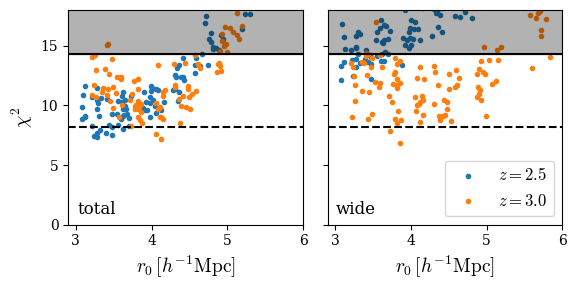

In [14]:
fig,axs = plt.subplots(1,2,figsize=(6,3))
for i in range(2):
    if i==0: fn = basedir+'mc/ibis_tertiary44_v4.2/r0_arr.json'
    else: fn = basedir+'mc/ibis_tertiary44_bright_v4.2/r0_arr.json'
    dd = json.load(open(fn,'r'))
    ax = axs[i]
    for j in range(1,3):
        zstr = 'z%d'%j
        r0 = np.array(dd[zstr]['r0'])
        chi2 = np.array(dd[zstr]['chi2'])
        chi2min = np.min(chi2)
        idxs = np.where(chi2<chi2min+2)[0]
        # idxs = np.where(chi2<chi2min+1)[0]

        r0mid = r0[np.argmin(chi2)]

        print('sample',i,zstr)
        print('r0 mid = %.2f'%(r0mid))
        print('r0 1sigma = %.2f - %.2f'%(np.min(r0[idxs]), np.max(r0[idxs])))

    ax.scatter(dd['z1']['r0'],dd['z1']['chi2'],marker='.')
    ax.scatter(dd['z2']['r0'],dd['z2']['chi2'],marker='.')
    ax.set_xlabel(r'$r_0\,[h^{-1}\text{Mpc}]$',fontsize=14)

    if i==0: ax.set_xlim(2.9,6)
    else: ax.set_xlim(2.9,6)
    ax.set_ylim(0,18)
    # ax.grid(alpha=.8,ls='--')

    ax.axhline(8.18,c='k',ls='--')
    ax.axhline(14.34,c='k',ls='-')
    ax.fill_between(np.linspace(2,7),14.34, 30,color='k',alpha=.3)

    if i==0:
        ax.set_ylabel(r'$\chi^2$',fontsize=14)
        ax.set_title(r'total',y=.01,x=.12)
    else:
        ax.set_yticklabels([])
        ax.scatter([],[],c='C0',label=r'$z=2.5$',marker='.')
        ax.scatter([],[],c='C1',label=r'$z=3.0$',marker='.')
        ax.legend(loc='lower right',fontsize=12)
        ax.set_title(r'wide',y=.01,x=.12)


fig.tight_layout()
# fig.savefig('plots/r0_chi2.pdf')
fig.show()